In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

In [16]:
pretty_agg_names = {
    'fedavg': 'FedAvg',
    'rfa_whole': 'RFA Whole',
    'rfa_component': 'RFA Component',
    'random_sample_simple_0_3': 'Simple Random Sample p = 0.3',
    'random_sample_simple_0_5': 'Simple Random Sample p = 0.5',
    'random_sample_simple_0_7': 'Simple Random Sample p = 0.7',
    'clusteragg_kmeans_3_average': 'ClusterAgg KMeans K = 3',
    'clusteragg_kmeans_5_average': 'ClusterAgg KMeans K = 5',
    'clusteragg_kmeans_8_average': 'ClusterAgg KMeans K = 8',
    'clusteragg_kmeans_3_median': 'ClusterAgg KMeans K = 3',
    'clusteragg_kmeans_5_median': 'ClusterAgg KMeans K = 5',
    'clusteragg_kmeans_8_median': 'ClusterAgg KMeans K = 8',
    'clusteragg_agglo_average': 'ClusterAgg Agglo Average',
    'clusteragg_agglo_median': 'ClusterAgg Agglo Median',
    'clusteragg_meanshift_average': 'ClusterAgg MeanShift Average',
    'clusteragg_meanshift_median': 'ClusterAgg MeanShift Median',
}

pretty_client_names = {
        'no_poison_no_straggle': 'No Poison / No Straggle',
        'yes_poison_no_straggle': 'Yes Poison / No Straggle',
        'no_poison_yes_straggle': 'No Poison / Yes Straggle',
        'yes_poison_yes_straggle': 'Yes Poison / Yes Straggle',
    }

def get_report_path(agg_type:str, task_type:str, client_type:str, staleness:bool = False) -> Path:
    agg_name = agg_type + '' if not staleness else '_staleness'
    return Path(f'../output/{agg_name}/{task_type}/{client_type}/report.csv')

def get_result(agg_type:str = 'fedavg', task_type:str = 'mnist_0_1', staleness:bool = False) -> pd.DataFrame:
    filenames = [
        get_report_path(agg_type, task_type, client_type)
        for client_type in pretty_client_names
    ]

    result_df = pd.DataFrame()
    if any([filename.is_file() for filename in filenames]):
        result_df = pd.concat([
            pd.read_csv(
                filename
            ).assign(**{
                "Client Type": client_type_name,
                "Aggregator Type": pretty_agg_names[agg_type],
                "Staleness": "Aware" if staleness else "Not Aware"
            })
            for client_type, client_type_name in pretty_client_names.items()
            if (filename:=get_report_path(agg_type, task_type, client_type)).is_file()
        ]).rename(
            columns = dict(
                accuracy_score = 'Accuracy Score',
                round = 'Round',
                queue_size = '# Withheld Updates',
                aggregator_time = 'Aggregator Runtime',
                client_train_acc_avg = 'Client Training Accuracy',
                client_test_acc_avg = 'Client Test Accuracy'
            )
        )
    # else:
    #     print('didnt find??')

    return result_df

all_regular_results = pd.concat([
    get_result(agg_type, 'mnist_0_1') 
    for agg_type in pretty_agg_names
])

all_stale_results = pd.concat([
    get_result(agg_type, 'mnist_0_1', True) 
    for agg_type in pretty_agg_names
])


all_results = pd.concat([all_regular_results,all_stale_results])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


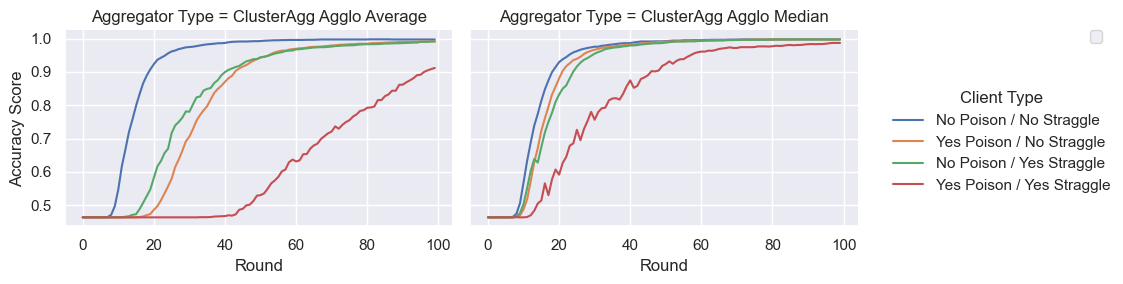

In [17]:


grid = sns.relplot(
    data=all_regular_results[all_regular_results['Aggregator Type'].str.contains('Agglo')],
    x = "Round", 
    y = "Accuracy Score", 
    col = "Aggregator Type", 
    hue = "Client Type", 
    kind="line",
    height=3,
    aspect = 1.5, 
    errorbar = None
)
plt.legend(bbox_to_anchor=(1.6, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()


## No staleness comparisons

### FedAvg 

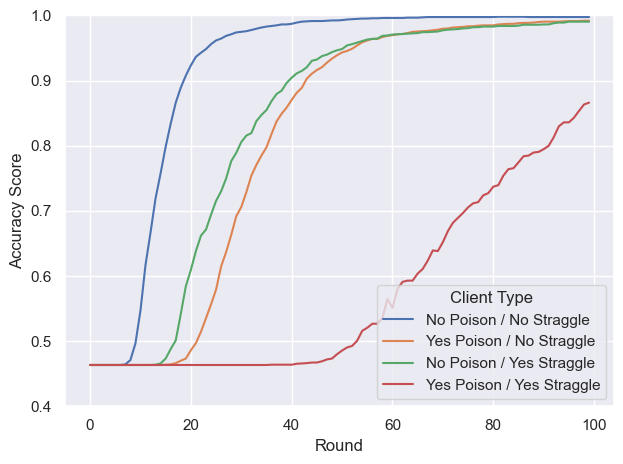

In [18]:
sns.set()


fig = sns.lineplot(
    data = all_regular_results[all_regular_results['Aggregator Type'].str.contains('FedAvg')],
    x = 'Round',
    y = 'Accuracy Score',
    hue = 'Client Type',
    errorbar=None
)
fig.set(
    ylim = (0.4, 1)
)
# plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()
fig.figure.savefig('../figures/fedavg.png', dpi = 300)



### Kmeans

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


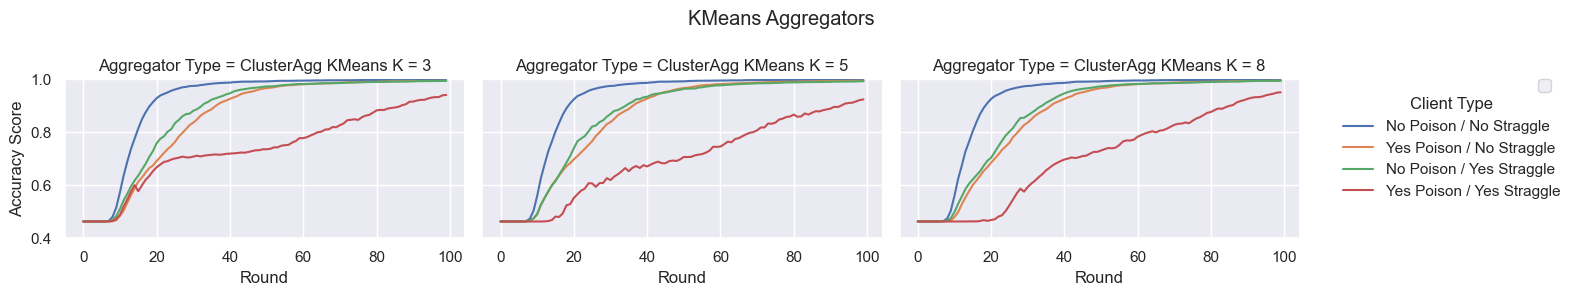

In [19]:

grid = sns.relplot(
    data=all_regular_results[all_regular_results['Aggregator Type'].str.contains('KMeans')],
    x = "Round", 
    y = "Accuracy Score", 
    col = "Aggregator Type", 
    hue = "Client Type", 
    kind="line",
    height=3,
    aspect = 1.5, 
    errorbar = None
)
grid.set(
    ylim = (0.4, 1),
    # suptitle = 'KMeans Aggregators'
)
grid.fig.suptitle(
    'KMeans Aggregators'
)
plt.legend(bbox_to_anchor=(1.6, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()
grid.figure.savefig('../figures/kmeans_comparison.png', dpi = 300)


### RFA component and Whole

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


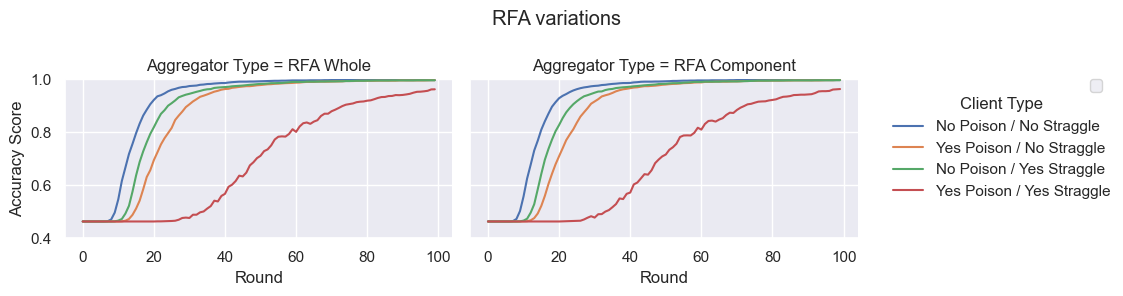

In [20]:

grid = sns.relplot(
    data=all_regular_results[all_regular_results['Aggregator Type'].str.contains('RFA')],
    x = "Round", 
    y = "Accuracy Score", 
    col = "Aggregator Type", 
    hue = "Client Type", 
    kind="line",
    height=3,
    aspect = 1.5, 
    errorbar = None
)
grid.set(
    ylim = (0.4, 1)
)
grid.fig.suptitle('RFA variations')
plt.legend(bbox_to_anchor=(1.6, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()
grid.figure.savefig('../figures/rfa_comparisons.png', dpi = 300)


### Agglomerative Comparisons

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


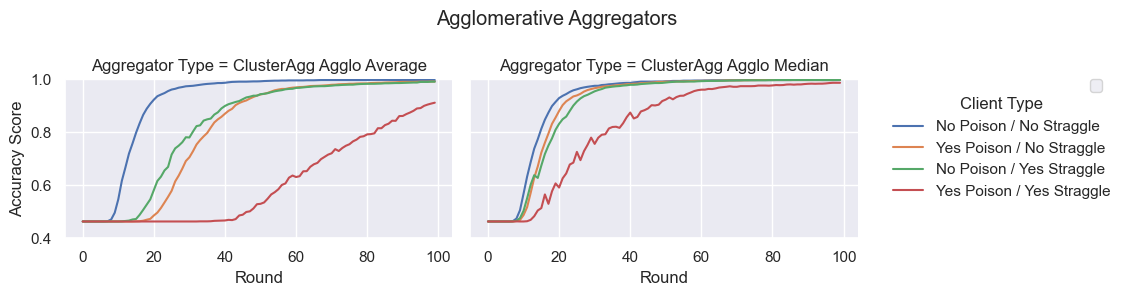

In [21]:

grid = sns.relplot(
    data=all_regular_results[all_regular_results['Aggregator Type'].str.contains('Agglo')],
    x = "Round", 
    y = "Accuracy Score", 
    col = "Aggregator Type", 
    hue = "Client Type", 
    kind="line",
    height=3,
    aspect = 1.5, 
    errorbar = None
)
grid.set(
    ylim = (0.4, 1)
)
grid.fig.suptitle('Agglomerative Aggregators')
plt.legend(bbox_to_anchor=(1.6, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()
grid.figure.savefig('../figures/agglo_comparisons.png', dpi = 300)


### MeanShift Clustering

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


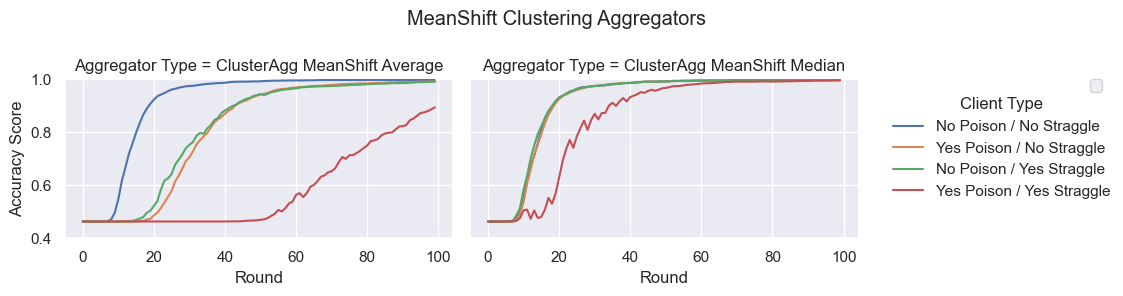

In [22]:

grid = sns.relplot(
    data=all_regular_results[all_regular_results['Aggregator Type'].str.contains('MeanShift')],
    x = "Round", 
    y = "Accuracy Score", 
    col = "Aggregator Type", 
    hue = "Client Type", 
    kind="line",
    height=3,
    aspect = 1.5, 
    errorbar = None
)
grid.set(
    ylim = (0.4, 1)
)
grid.fig.suptitle('MeanShift Clustering Aggregators')
plt.legend(bbox_to_anchor=(1.6, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()
grid.figure.savefig('../figures/meanshift_comparisons.png', dpi = 300)


### Random Sampling Comparisons

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


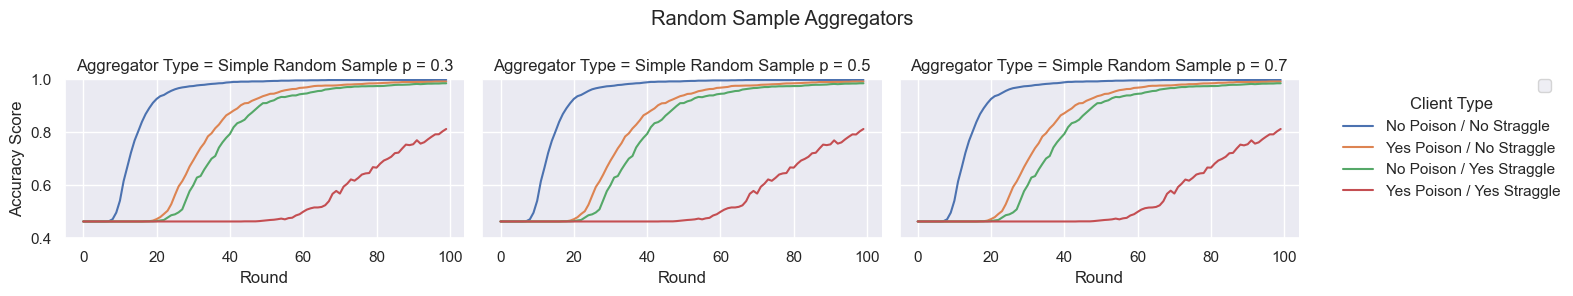

In [12]:
grid = sns.relplot(
    data=all_regular_results[all_regular_results['Aggregator Type'].str.contains('Random Sample')],
    x = "Round", 
    y = "Accuracy Score", 
    col = "Aggregator Type", 
    hue = "Client Type", 
    kind="line",
    height=3,
    aspect = 1.5, 
    errorbar = None
)
grid.set(
    ylim = (0.4, 1)
)
grid.fig.suptitle('Random Sample Aggregators')
plt.legend(bbox_to_anchor=(1.6, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()
grid.figure.savefig('../figures/random_sample_comparisons.png', dpi = 300)


### Runtime comparison

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


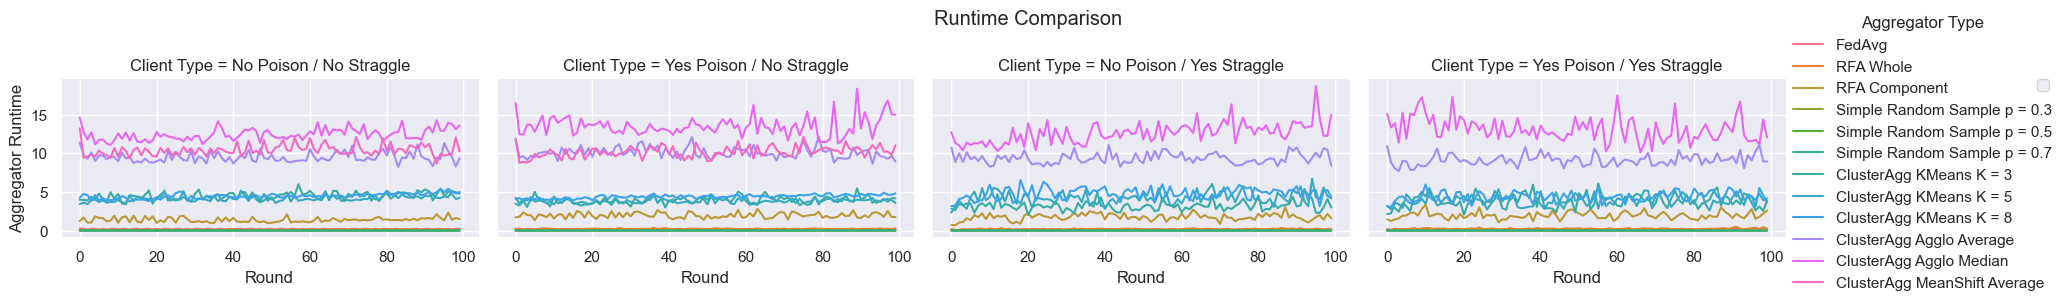

In [14]:

grid = sns.relplot(
    data=all_regular_results,
    x = "Round", 
    y = "Aggregator Runtime", 
    hue = "Aggregator Type", 
    col = "Client Type", 
    kind="line",
    height=3,
    aspect = 1.5, 
    errorbar = None
)
# grid.set(
#     ylim = (0.4, 1)
# )
grid.fig.suptitle('Runtime Comparison')
plt.legend(bbox_to_anchor=(1.6, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()
grid.figure.savefig('../figures/runtime_comparison.png', dpi = 300)


## Staleness Aware comparisons

### FedAvg

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


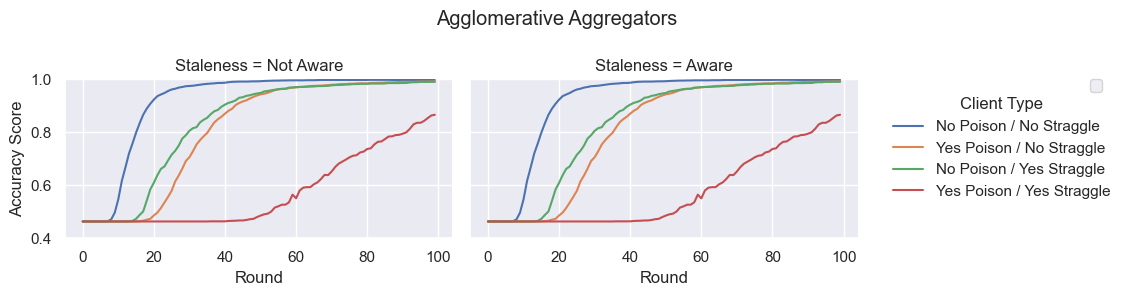

In [10]:

grid = sns.relplot(
    data=all_results[all_results['Aggregator Type'].str.contains('FedAvg')],
    x = "Round", 
    y = "Accuracy Score", 
    col = "Staleness", 
    hue = "Client Type", 
    kind="line",
    height=3,
    aspect = 1.5, 
    errorbar = None
)
grid.set(
    ylim = (0.4, 1)
)
grid.fig.suptitle('Agglomerative Aggregators')
plt.legend(bbox_to_anchor=(1.6, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()
grid.figure.savefig('../figures/fedavg_staleness_comparison.png', dpi = 300)


In [11]:
all_regular_results[all_regular_results['Aggregator Type'] == 'FedAvg']['Accuracy Score'] == all_stale_results[all_stale_results['Aggregator Type'] == 'FedAvg']['Accuracy Score']

0     True
1     True
2     True
3     True
4     True
      ... 
95    True
96    True
97    True
98    True
99    True
Name: Accuracy Score, Length: 400, dtype: bool